<a href="https://colab.research.google.com/github/cptchipmonk/ComputerVision2018-19/blob/master/nlp_coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip install --upgrade gensim
!pip install --upgrade sklearn
!pip install --upgrade GPy
!pip install --upgrade GPyOpt


    100% |████████████████████████████████| 91.1MB 134.1MB/s 
    100% |████████████████████████████████| 2.0MB 13.0MB/s 
imgaug 0.2.8 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
fastai 1.0.46 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
fastai 1.0.46 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
    100% |████████████████████████████████| 24.2MB 1.7MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


Requirement already up-to-date: sklearn in /usr/local/lib/python3.6/dist-packages (0.0)
    100% |████████████████████████████████| 880kB 21.1MB/s 
    100% |████████████████████████████████| 71kB 24.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/97/82/1d/32a361e1ff2b4d9129a60343831dd99cdc74440e2db1c55264
  Stored in directory: /root/.cache/pip/wheels/a9/fc/74/3bbd263c43ed98d67343df24cebf0a0ee34afee40d769fda9c
Successfully built GPy paramz
    100% |████████████████████████████████| 61kB 4.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/33/1d/87/dc02440831ba986b1547dd11a7dcd44e893b0527083066d869
Successfully built GPyOpt


In [0]:
import torch
# from torch.autograd import Variable
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# from tqdm import tqdm 
# import codecs
import random


#we fix the seeds to get consistent results

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)



# Use GPU
USE_GPU = True
# dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


In [178]:
#Method for importing datasets
from google.colab import files
files.upload()

Saving offenseval-training-v1.tsv to offenseval-training-v1 (1).tsv
Saving test_set_taskc.tsv to test_set_taskc (1).tsv
Saving testset-taska.tsv to testset-taska (1).tsv
Saving testset-taskb.tsv to testset-taskb (1).tsv


{'offenseval-training-v1.tsv': b'id\ttweet\tsubtask_a\tsubtask_b\tsubtask_c\r\n86426\t@USER She should ask a few native Americans what their take on this is.\tOFF\tUNT\tNULL\r\n90194\t@USER @USER Go home you\xe2\x80\x99re drunk!!! @USER #MAGA #Trump2020 \xf0\x9f\x91\x8a\xf0\x9f\x87\xba\xf0\x9f\x87\xb8\xf0\x9f\x91\x8a URL\tOFF\tTIN\tIND\r\n16820\tAmazon is investigating Chinese employees who are selling internal data to third-party sellers looking for an edge in the competitive marketplace. URL #Amazon #MAGA #KAG #CHINA #TCOT\tNOT\tNULL\tNULL\r\n62688\t"@USER Someone should\'veTaken"" this piece of shit to a volcano. \xf0\x9f\x98\x82"""\tOFF\tUNT\tNULL\r\n43605\t@USER @USER Obama wanted liberals &amp; illegals to move into red states\tNOT\tNULL\tNULL\r\n97670\t@USER Liberals are all Kookoo !!!\tOFF\tTIN\tOTH\r\n77444\t@USER @USER Oh noes! Tough shit.\tOFF\tUNT\tNULL\r\n52415\t@USER was literally just talking about this lol all mass shootings like that have been set ups. it\xe2\x80\x99s 

In [0]:
# create stopword list, taken from NLTK. Removed not, nor and no as I deemed
# these words to have sentimental value for this project.

stopwords = ["what", "which", "who", "whom", "this", "that", "these", "those",
 "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had",
 "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", 
 "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", 
 "about", "against", "between", "into", "through", "during", "before", "after",
 "above", "below", "to", "from", "up", "down", "in",
 "under", "again", "further", "then", "once", "here", "there", "when", "where",
 "why", "how", "all", "any", "both", "each", "few", "other",
 "some", "such", "own", "same", "so", "than", "too",
 "very", "s", "t", "can", "will", "just", "don", "should", "now"]

# Section 1: Processing input data

**Read in the train data and preprocess.
The training labels are read as well.**
Data is read from the traind data .tsv file. The tweets are tokenized and stored in corpus. The labels are stored in their respective arrays. A tokenized corpus is created for each task (A,B and C) as certain tweets cannot be used for tasks B and C due to having NULL values.

In [0]:
# import data
import csv
import re

def preprocess_tweet(tweet, remove_stopwords = False):
  # remove @USER and URL
  tweet = re.sub('\@USER', '', tweet)
  tweet = re.sub('URL', '', tweet)

  # remove non-alphabetical characters (keep apostrophes and spaces as well)
  tweet = re.sub('[^A-Za-z \']', '', tweet)

  # make lowercase
  tweet = tweet.lower()

  # make all words separated by one space      
  tweet = re.sub('  *', " ", tweet)

  # remove stop-words and create tokenized list
  tokenized_sentence = []
  for token in tweet.split(' '):
#       if token not in stopwords:
    if token not in ['']:
      tokenized_sentence.append(token)
      
  return tokenized_sentence

# data_dir = './OffensEval_task_data/start-kit/training-v1/offenseval-training-v1.tsv'
data_dir = 'offenseval-training-v1.tsv'
remove_stopwords = True

# Get training data (tweets) and labels (for a b and c seperately)
with open(data_dir,'r') as tsvin:
  tsvin = csv.reader(tsvin, delimiter='\t')
  tokenized_corpus_A = []
  tokenized_corpus_B = []
  tokenized_corpus_C = []
  taskA_labels = []
  taskB_labels = []
  taskC_labels = []
  
  for row in tsvin:
      
    tokenized_sentence = preprocess_tweet(row[1], remove_stopwords = remove_stopwords)
    tokenized_corpus_A.append(tokenized_sentence)
    # Collect task A labels
    
    if row[2] == "OFF":
      taskA_labels.append(1)
    elif row[2] == "NOT":
      taskA_labels.append(0)
      
    # Collect task B labels
    if row[3] == "TIN":
      taskB_labels.append(1)
    elif row[3] == "UNT":
      taskB_labels.append(0)
    if row[3] != "NULL":
      tokenized_corpus_B.append(tokenized_sentence)
      
    # Collect task C labels
    if row[4] == "IND":
      taskC_labels.append(0)
    elif row[4] == "GRP":
      taskC_labels.append(1)
    elif row[4] == "OTH":
      taskC_labels.append(2)
    if row[4] != "NULL":
      tokenized_corpus_C.append(tokenized_sentence)
    

# removes column titles from corpus
tokenized_corpus_A = tokenized_corpus_A[1:]
tokenized_corpus_B = tokenized_corpus_B[1:]
tokenized_corpus_C = tokenized_corpus_C[1:]


**Defining the word to vector function that will generate an indexing dictionary for the words in the corpus.**

In [0]:
def get_word2idx(tokenized_corpus):
  vocabulary = []
  for sentence in tokenized_corpus:
    for token in sentence:
        if token not in vocabulary:
            vocabulary.append(token)
  
  
  word2idx = {w: idx+1 for (idx, w) in enumerate(vocabulary)}
  # we reserve the 0 index for the placeholder token
  word2idx['<pad>'] = 0
 
  return word2idx


**The data is converted into a form to be passed into the classifiers i.e each tokenized tweet will be converted into index form rather than text form.** All tweets will be made a fixed length as specified by max_len. If a tweet is shorter than max_len then it will be extended with \<pad\> values. If the tweet is longer then it will be cropped.

In [0]:
import torch.utils.data as data_utils


def get_model_inputs(tokenized_corpus, word2idx, labels=[], max_len=16):
  
  vectorized_tweets = [[word2idx[tok] for tok in sent if tok in word2idx] for sent in tokenized_corpus]
  
  # create a tensor of a fixed size filled with zeroes for padding

  sent_tensor = torch.zeros((len(vectorized_tweets), max_len))
  
  # find lengths of tweets, limit to max_len if tweet longer than max_len words
  sent_lengths = [len(sent) for sent in vectorized_tweets]
  for i in range(len(sent_lengths)):
    if sent_lengths[i] > max_len:
      sent_lengths[i] = max_len
  
  # fill it with  vectorized sentences 
  
  for idx, (sent, sentlen) in enumerate(zip(vectorized_tweets, sent_lengths)):

    sent_tensor[idx, :sentlen] = torch.LongTensor(sent[:sentlen])
  if labels != []:
    label_tensor = torch.LongTensor(labels)
  else:
    label_tensor = []
  
  return sent_tensor.long(), label_tensor

def get_model_labels(labels):
  label_tensor = torch.LongTensor(labels)
  return label_tensor

# Create dictionary for vocabulary
word2idx = get_word2idx(tokenized_corpus_A)

# Set model parameters: length of inputs, and embedding dimension
vocab_size = len(word2idx)
max_len = 45
embedding_dim = 100


# Create dataset for task A
train_A_data, train_A_labels = get_model_inputs(tokenized_corpus_A, word2idx, labels=taskA_labels, max_len=max_len)
train_B_data, train_B_labels = get_model_inputs(tokenized_corpus_B, word2idx, labels=taskB_labels, max_len=max_len)
train_C_data, train_C_labels = get_model_inputs(tokenized_corpus_C, word2idx, labels=taskC_labels, max_len=max_len)

# Data loaders, not used in hyperparameter tuning but used in training the final models for predictions
Task_A_dataset = data_utils.TensorDataset(train_A_data, train_A_labels)
train_A_loader = data_utils.DataLoader(Task_A_dataset, batch_size=64, num_workers=4, shuffle=True)

Task_B_dataset = data_utils.TensorDataset(train_B_data, train_B_labels)
train_B_loader = data_utils.DataLoader(Task_B_dataset, batch_size=64, num_workers=4, shuffle=True)

Task_C_dataset = data_utils.TensorDataset(train_C_data, train_C_labels)
train_C_loader = data_utils.DataLoader(Task_C_dataset, batch_size=64, num_workers=4, shuffle=True)



**A word model is made for the corpus/vocab of this data.** This is done using gensim's Word2Vec function. The embeedding dimension is decided by embedding_dim. This word model is then coverted into an embedding matrix to be passed to the classifying networks later.

In [0]:
import gensim
from gensim.models import Word2Vec

# Create word embedding dictionary with gensim
word_model = Word2Vec(sentences = tokenized_corpus_A, size = embedding_dim, window = 5, min_count = 1, workers = 4, sg = 1)


In [0]:
# creating embedding matrix from word_model

embedding_matrix = []
embedding_matrix.append([0]*embedding_dim)
# print(embedding_matrix)
for word, index in word2idx.items():
  if word == '<pad>':
    print("i")
    x = 1 #do nothing, already added
  else:
    embedding_matrix.append(word_model.wv[word])

  
embedding_matrix = torch.tensor(embedding_matrix)


i
torch.Size([20496, 100])


**Defining the CNN class used for semantic classifiation.**

In [0]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, out_channels, window_size, output_dim, dropout):
        
        super(CNN, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #in_channels -- 1 text channel
        #out_channels -- the number of output channels
        #kernel_size is (window size x embedding dim)
        
        self.conv = nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=(window_size,embedding_dim))
        
        self.dropout = nn.Dropout(dropout)
    
        self.fc = nn.Linear(out_channels, output_dim)
        
        
        
    def forward(self, x):
                

        embedded = self.embedding(x)

        embedded = embedded.unsqueeze(1)
        
        feature_maps = F.relu(self.conv(embedded))

        feature_maps = feature_maps.squeeze(3)

        pooled = F.max_pool1d(feature_maps, feature_maps.shape[2])
        
        pooled = pooled.squeeze(2)
        
        dropped = self.dropout(pooled)
 
        preds = self.fc(dropped)
        
        return preds
   
  
# Was not used in the end. Was simply a deeper CNN but it didn't improve performance
class CNN2(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, out_channels, window_size, output_dim, dropout):
        
        super(CNN2, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #in_channels -- 1 text channel
        #out_channels -- the number of output channels
        #kernel_size is (window size x embedding dim)
        
        self.conv = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(window_size,50), stride = (1,50))
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,2))
        
        
        #the dropout layer
        self.dropout = nn.Dropout(dropout)
    
        #the output layer
        self.fc = nn.Linear(128, output_dim)
        
        
        
    def forward(self, x):
                

        embedded = self.embedding(x)

        embedded = embedded.unsqueeze(1)

        feature_maps = F.relu(self.conv(embedded))

        feature_maps = feature_maps.squeeze(3)

        feature_maps = F.relu(self.conv2(feature_maps))

        feature_maps = feature_maps.squeeze(3)

        pooled = F.max_pool1d(feature_maps, feature_maps.shape[2])

        pooled = pooled.squeeze(2)

        preds = self.fc(pooled)

        return preds
    


# Section 2: Training the models

**Defining methods for training and testing classifiers.** K-fold cross-validation training can be done with run_cross_validation, and training of a single model done with train_model. Two functions are defined for testing the performance of models: accuracy and f_measure.

In [0]:
import sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import copy

# Not used anymore
def accuracy(output, target):
 
    output = torch.round(torch.sigmoid(output))
    correct = (output == target).float()
    acc = correct.sum()/len(correct)
    return acc

def f_measure(output, target):
  
  
    pred = torch.round(torch.sigmoid(output))
    pred = pred.detach().cpu().numpy().astype(int)
    target = target.detach().cpu().numpy().astype(int)
    score = f1_score(pred, target, average = 'macro')
    return score
      
def run_cross_validation(x_train,y_train, n_splits, n_epochs, model_original, optimiser_args, loss_fn):
    
    val_f_scores = []

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    # For each fold
    for f, (train_idx, valid_idx) in enumerate(kf.split(x_train)):
        
        training_losses = []
        validation_losses = []
        
        x_train_fold = x_train[train_idx]
        y_train_fold = y_train[train_idx]
        
        x_val_fold = x_train[valid_idx]
        y_val_fold = y_train[valid_idx]     

        model = copy.deepcopy(model_original)        
        model = model.to(device=device)

        optimiser = optim.Adam(model.parameters(), lr=optimiser_args[0], weight_decay = optimiser_args[1])
        
        
        train_dataset = data_utils.TensorDataset(x_train_fold, y_train_fold)
        train_loader = data_utils.DataLoader(train_dataset, batch_size=64, num_workers=4, shuffle=True)
        
        val_dataset = data_utils.TensorDataset(x_val_fold, y_val_fold)
        val_loader = data_utils.DataLoader(val_dataset, batch_size=64, num_workers=4, shuffle=True)
        
        print(f'Fold {f + 1}')
        print_every = 1
        
        for e in range(1, epochs+1):
            for t, (x, y) in enumerate(train_loader):
                model.train()  # put model to training mode
                x = x.to(device=device, dtype=torch.long)  # move to device, e.g. GPU
                y = y.to(device=device, dtype=torch.long)

                # Zero out all of the gradients for the variables which the optimiser
                # will update.
                optimiser.zero_grad()


                predictions = model(x)      
                predictions = predictions.squeeze(1)

                loss = loss_fn(predictions.float(), y.float())
                f_val = f_measure(predictions.float(), y.float())
                                
                loss.backward()

                optimiser.step()
                
            # Get validation loss at each epoch
            with torch.no_grad():

                val_loss_epoch =0.
                no_batches = 0
                for i, (x_val, y_val) in enumerate(val_loader):

                    val_predictions = model(x_val).squeeze(1)

                    val_loss_epoch += loss_fn(val_predictions.float(), y_val.float())
                    no_batches = i+1
                    
                    
                val_loss_epoch = (val_loss_epoch/no_batches).item()
                training_losses.append(loss.item())
                validation_losses.append(val_loss_epoch)

            if t % print_every == 0:
                print(f'| Epoch: {e:02} | Train Loss: {loss:.3f} | Train f-score: {f_val:.3f} | validation loss: {val_loss_epoch:.3f}')
                #check_accuracy(loader_val, model)
                print()

        model.eval()
        with torch.no_grad():
        
            avg_val_f_val = 0.
            no_batches = 0
            for i, (x_val, y_val) in enumerate(val_loader):

                val_predictions = model(x_val).squeeze(1)

                avg_val_f_val += f_measure(val_predictions.float(), y_val.float())
                no_batches = i+1


            total_val_acc = (avg_val_f_val / no_batches).item()
            val_f_scores.append(total_val_acc)
            print("Training losses:", training_losses)
            print("Validation losses:", validation_losses)
            print("Fold = ", f+1, ", Validation f-measure score = ", total_val_acc)

        

    total_validation_accuracy = np.mean(val_f_scores)
    print("##### Training complete. Model validation f-measure score = ", total_validation_accuracy, "#####")
    return total_validation_accuracy

def train_model(model, optimiser, train_data_loader, loss_fn, epochs=1):
  """
  Train a model on CIFAR-10 using the PyTorch Module API.

  Inputs:
  - model: A PyTorch Module giving the model to train.
  - optimiser: An Optimizer object we will use to train the model
  - train_data_loader: the data to train with, in a Pytorch data_loader
  - epochs: (Optional) A Python integer giving the number of epochs to train for

  Returns: Nothing, but prints model accuracies during training.
  """
  print_every = 1
  model = model.to(device=device)  # move the model parameters to CPU/GPU

  for e in range(1, epochs+1):

    for t, (x, y) in enumerate(train_data_loader):
      model.train()  # put model to training mode
      x = x.to(device=device, dtype=torch.long)  # move to device, e.g. GPU
      y = y.to(device=device, dtype=torch.long)

      # Zero out all of the gradients for the variables which the optimiser
      # will update.
      optimiser.zero_grad()


      predictions = model(x)      
      predictions = predictions.squeeze(1)

      loss = loss_fn(predictions.float(), y.float())

      loss.backward()

      # Update the parameters of the model using the gradients
      optimiser.step()

    if t % print_every == 0:
      print(f'| Epoch: {e:02} | Train Loss: {loss:.3f}')
      #check_accuracy(loader_val, model)
      print()



In [0]:
def one_hot2index(predictions):
  indexes = []
  for pred in predictions:
      max_index = 0
      max_val = 0.

      for i,val in enumerate(pred):

          if val > max_val:
              max_index = i
              max_val = val;
      indexes.append(max_index)
    
  return torch.tensor(indexes)


def run_cross_validation_for_C(x_train,y_train, n_splits, n_epochs, model_original, optimiser_args, loss_fn):
    
    val_f_scores = []

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    # For each fold
    for f, (train_idx, valid_idx) in enumerate(kf.split(x_train)):
        
        training_losses = []
        validation_losses = []
        
        x_train_fold = x_train[train_idx]
        y_train_fold = y_train[train_idx]
        
        x_val_fold = x_train[valid_idx]
        y_val_fold = y_train[valid_idx]     

        model = copy.deepcopy(model_original)        
        model = model.to(device=device)
        

        optimiser = optim.Adam(model.parameters(), lr=optimiser_args[0], weight_decay = optimiser_args[1])
        
        
        train_dataset = data_utils.TensorDataset(x_train_fold, y_train_fold)
        train_loader = data_utils.DataLoader(train_dataset, batch_size=64, num_workers=4, shuffle=True)
        
        val_dataset = data_utils.TensorDataset(x_val_fold, y_val_fold)
        val_loader = data_utils.DataLoader(val_dataset, batch_size=64, num_workers=4, shuffle=True)
        
        print(f'Fold {f + 1}')
        print_every = 1
        
        for e in range(1, epochs+1):
            for t, (x, y) in enumerate(train_loader):
                model.train()  # put model to training mode
                x = x.to(device=device, dtype=torch.long)  # move to device, e.g. GPU
                y = y.to(device=device, dtype=torch.long)

                # Zero out all of the gradients for the variables which the optimiser
                # will update.
                optimiser.zero_grad()


                predictions = model(x)      
                predictions = predictions.squeeze(1)

                loss = loss_fn(predictions.float(), y) # Changed to long for task C
                
                predictions = one_hot2index(predictions)
                f_val = f_measure(predictions.float(), y.float())
                
                
                loss.backward()
                # Update the parameters of the model using the gradients
                optimiser.step()
                
            with torch.no_grad():

                val_loss_epoch =0.
                no_batches = 0
                for i, (x_val, y_val) in enumerate(val_loader):

                    val_predictions = model(x_val).squeeze(1)

                    val_loss_epoch += loss_fn(val_predictions.float(), y_val)
                    no_batches = i+1
                    
                    
                val_loss_epoch = (val_loss_epoch/no_batches).item()
                training_losses.append(loss.item())
                validation_losses.append(val_loss_epoch)

            if t % print_every == 0:
                print(f'| Epoch: {e:02} | Train Loss: {loss:.3f} | Train f-score: {f_val:.3f} | validation loss: {val_loss_epoch:.3f}')
                #check_accuracy(loader_val, model)
                print()

        model.eval()
        with torch.no_grad():
        
            avg_val_f_val = 0.
            no_batches = 0
            for i, (x_val, y_val) in enumerate(val_loader):

                val_predictions = model(x_val).squeeze(1)
                val_predictions = one_hot2index(val_predictions)

                avg_val_f_val += f_measure(val_predictions.float(), y_val.float())
                no_batches = i+1


            total_val_acc = (avg_val_f_val / no_batches).item()
            val_f_scores.append(total_val_acc)
            print("Training losses:", training_losses)
            print("Validation losses:", validation_losses)
            print("Fold = ", f+1, ", Validation f-measure score = ", total_val_acc)

        model = model.to(device='cpu')
        

    total_validation_accuracy = np.mean(val_f_scores)
    print("##### Training complete. Model validation f-measure score = ", total_validation_accuracy, "#####")
    return total_validation_accuracy

def train_model_for_C(model, optimiser, train_data_loader, loss_fn, epochs=1):
  """
  Train a model on CIFAR-10 using the PyTorch Module API.

  Inputs:
  - model: A PyTorch Module giving the model to train.
  - optimiser: An Optimizer object we will use to train the model
  - train_data_loader: the data to train with, in a Pytorch data_loader
  - epochs: (Optional) A Python integer giving the number of epochs to train for

  Returns: Nothing, but prints model accuracies during training.
  """
  print_every = 1
  model = model.to(device=device)  # move the model parameters to CPU/GPU

  for e in range(1, epochs+1):

    for t, (x, y) in enumerate(train_data_loader):
      model.train()  # put model to training mode
      x = x.to(device=device, dtype=torch.long)  # move to device, e.g. GPU
      y = y.to(device=device, dtype=torch.long)

      # Zero out all of the gradients for the variables which the optimiser
      # will update.
      optimiser.zero_grad()


      predictions = model(x)      
      predictions = predictions.squeeze(1)

      loss = loss_fn(predictions.float(), y)

      loss.backward()

      # Update the parameters of the model using the gradients
      optimiser.step()

    if t % print_every == 0:
      print(f'| Epoch: {e:02} | Train Loss: {loss:.3f}')
      #check_accuracy(loader_val, model)
      print()


Some variable definitions for training.

In [0]:

epochs=10
n_splits = 3
x_train = train_C_data
y_train = train_C_labels

INPUT_DIM = len(word2idx)
DROPOUT = 0.2

# Note: these were changed between tasks to account for different output dims
OUTPUT_DIM = 3
loss_fn = nn.CrossEntropyLoss()

In [0]:
import GPy
import GPyOpt

best_loss = 100000.

# loss function to be optimised by Bayesian optimisation
def calculate_loss(params):
  params = params[0]
  window_size = int(params[2])
  no_features = int(params[3])
  print(params)
  model = CNN(INPUT_DIM, embedding_dim, no_features, window_size, OUTPUT_DIM, DROPOUT)
  model.embedding.weight.data.copy_(embedding_matrix)
  
  optimizer_args = [params[0],params[1]]
  
  # CHANGE FOR A/B/C
  val_acc = run_cross_validation_for_C(x_train, y_train, n_splits, epochs, model, optimizer_args, loss_fn)
  
  loss = 1 - val_acc
  
  print("Model learning_rate = ", params[0])
  print("Model weight_decay = ", params[1])
  print("Model window size = ", params[2])
  print("Model no_features = ", params[3])
  global best_loss
  
  if loss <= best_loss:
    best_loss = loss
    torch.save(model.state_dict(), 'model.pt')
    print("New best model saved. Accuracy =", val_acc)
  
  return loss


# Run GPy implementation of Bayesian optimisation, optimising th e learning rate
# and weight decay of the model
bounds = [{'name': 'lr', 'type': 'continuous', 'domain': (0.,0.02)},
          {'name': 'wd', 'type': 'continuous', 'domain': (0.,0.01)},
          {'name': 'window', 'type': 'discrete', 'domain': range(1,5,1)},
          {'name': 'features', 'type': 'discrete', 'domain': range(32,256,1)}]
max_iter = 12
eps      = 10e-6

bayesian_opt = GPyOpt.methods.BayesianOptimization(calculate_loss, bounds)
bayesian_opt.run_optimization(max_iter = max_iter, eps = eps)

print("Best parameters values = ", bayesian_opt.x_opt)
print()
best_acc = 1 - bayesian_opt.fx_opt
print("Best accuracy = ", best_acc)

# Section 3: Testing

After optimal hyper-parameter values were found using Bayesian Optimisation, the optimal models for each task were recreated and trained. The test datasets were then used to generate predictions. These prediction were then submitted to CodaLab for scoring.

In [0]:
def process_test_tweets(filename):
    with open(filename,'r') as tsvin:
        tsvin = csv.reader(tsvin, delimiter='\t')

        id_list = []
        tokenized_corpus = []

        for row in tsvin:

            id_list.append(row[0])
            tokenized_sentence = preprocess_tweet(row[1], remove_stopwords = remove_stopwords)
            tokenized_corpus.append(tokenized_sentence)

    return tokenized_corpus[1:], id_list[1:]

tokenized_A_test, id_A = process_test_tweets('testset-taska.tsv')
tokenized_B_test, id_B = process_test_tweets('testset-taskb.tsv')
tokenized_C_test, id_C = process_test_tweets('test_set_taskc.tsv')

tokenized_A_test,_ = get_model_inputs(tokenized_A_test, word2idx, max_len=max_len)
tokenized_B_test,_ = get_model_inputs(tokenized_B_test, word2idx, max_len=max_len)
tokenized_C_test,_ = get_model_inputs(tokenized_C_test, word2idx, max_len=max_len)

tokenized_A_test = torch.tensor(tokenized_A_test).long()
tokenized_B_test = torch.tensor(tokenized_B_test).long()
tokenized_C_test = torch.tensor(tokenized_C_test).long()

**Running optimal models to generate data for analysis.**

In [0]:
epochs = 10
n_splits = 3
DROPOUT = 0.2
n_splits = 1

model_A_params = [5.77907131e-03, 6.24186551e-04, 4, 101]
model_B_params = [2.84460789e-03, 0, 4, 126]
model_C_params = [7.27786911e-03, 6.62652261e-03, 3, 186]

model_A = CNN(INPUT_DIM, embedding_dim, model_A_params[3], model_A_params[2], 1, DROPOUT)
model_A.embedding.weight.data.copy_(embedding_matrix)
optimiser_A = optim.Adam(model_A.parameters(), lr=model_A_params[0], weight_decay = model_A_params[1])


model_B = CNN(INPUT_DIM, embedding_dim, model_B_params[3], model_B_params[2], 1, DROPOUT)
model_B.embedding.weight.data.copy_(embedding_matrix)
optimiser_B = optim.Adam(model_B.parameters(), lr=model_B_params[0], weight_decay = model_B_params[1])

model_C = CNN(INPUT_DIM, embedding_dim, model_C_params[3], model_C_params[2], 3, DROPOUT)
model_C.embedding.weight.data.copy_(embedding_matrix)
optimiser_C = optim.Adam(model_B.parameters(), lr=model_C_params[0], weight_decay = model_C_params[1])


optimizer_args_A = [model_A_params[0], model_A_params[1]]
optimizer_args_B = [model_B_params[0], model_B_params[1]]
optimizer_args_C = [model_C_params[0], model_C_params[1]]
loss_fn_AB = nn.BCEWithLogitsLoss()
loss_fn_C = nn.CrossEntropyLoss()

# train_model(model_A, optimiser_A, train_A_loader, loss_fn_AB, epochs = epochs)
# train_model(model_B, optimiser_B, train_B_loader, loss_fn_AB, epochs = epochs)
# train_model_for_C(model_C, optimiser_C, train_C_loader, loss_fn_C, epochs = epochs)

run_cross_validation(train_A_data, train_A_labels, n_splits, epochs, model_A, optimizer_args_A, loss_fn_AB)
run_cross_validation(train_B_data, train_B_labels, n_splits, epochs, model_B, optimizer_args_B, loss_fn_AB)
run_cross_validation_for_C(train_C_data, train_C_labels, n_splits, epochs, model_C, optimizer_args_C, loss_fn_C)
    

**Plotting data from optimal models**

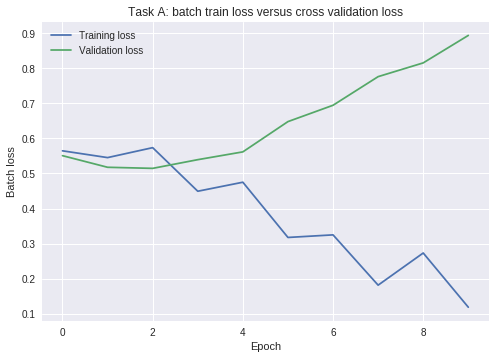

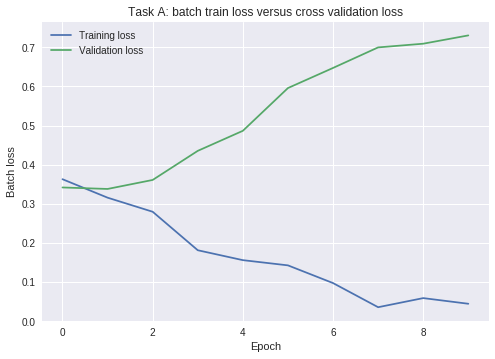

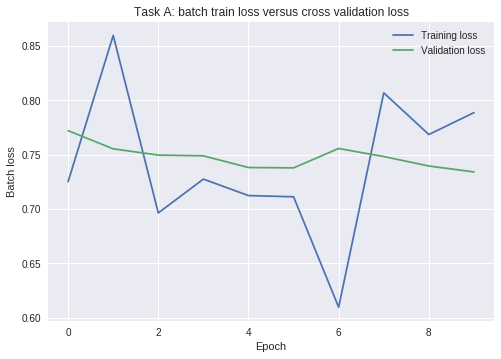

In [0]:
import matplotlib
import matplotlib.pyplot as plt

def plot_loss_plot(figure_number, train_loss, val_loss):
    avg_train_loss = np.mean(train_loss, axis=0)
    avg_val_loss = np.mean(val_loss, axis=0)
    plt.figure(figure_number)
    plt.plot(avg_train_loss, label = 'Training loss');
    plt.plot(avg_val_loss, label = 'Validation loss');
    plt.legend()
    plt.title("Task A: batch train loss versus cross validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Batch loss")

training_losses_A = [[0.6673604846000671, 0.533661961555481, 0.602737545967102, 0.47379687428474426, 0.47205713391304016, 0.42020076513290405, 0.3648760914802551, 0.12216479331254959, 0.27762457728385925, 0.06580737978219986],
                   [0.48591187596321106, 0.5348865985870361, 0.4102703928947449, 0.527822732925415, 0.5512225031852722, 0.32142210006713867, 0.39786556363105774, 0.2183208465576172, 0.13593867421150208, 0.1269506812095642],
                   [0.5404124855995178, 0.567058265209198, 0.7077288627624512, 0.34621161222457886, 0.4016619026660919, 0.21067383885383606, 0.21165095269680023, 0.20364920794963837, 0.4056759774684906, 0.16262109577655792],
                  ]

validation_losses_A = [[0.5723077654838562, 0.5279400944709778, 0.5139360427856445, 0.5307905077934265, 0.5589331984519958, 0.6475463509559631, 0.6828112602233887, 0.7833412885665894, 0.8026705980300903, 0.9115176796913147],
                    [0.5505525469779968, 0.520865261554718, 0.5182132720947266, 0.558269739151001, 0.5657120943069458, 0.6393349170684814, 0.6939689517021179, 0.7806087732315063, 0.8125221133232117, 0.8860869407653809],
                    [0.5293143391609192, 0.5040033459663391, 0.5114085078239441, 0.5288394689559937, 0.5599910616874695, 0.6567686200141907, 0.7067152857780457, 0.7644670009613037, 0.8309451937675476, 0.8836832046508789]]

training_losses_B = [[0.47472989559173584, 0.27142345905303955, 0.19560590386390686, 0.19322049617767334, 0.15755240619182587, 0.18787220120429993, 0.09647194296121597, 0.010449681431055069, 0.08498784899711609, 0.012937325052917004],
                     [0.3367938995361328, 0.4151855409145355, 0.22503964602947235, 0.19650405645370483, 0.20557767152786255, 0.17988011240959167, 0.1195756047964096, 0.06465745717287064, 0.07205889374017715, 0.070358045399189],
                     [0.27723485231399536, 0.2605533003807068, 0.4184320569038391, 0.15416431427001953, 0.1047166958451271, 0.06008577719330788, 0.07592637091875076, 0.03172176703810692, 0.01964803785085678, 0.04999414086341858]
                    ]
validation_losses_B = [[0.3394359052181244, 0.33305373787879944, 0.35537484288215637, 0.3822886347770691, 0.4518278241157532, 0.5740465521812439, 0.6279687285423279, 0.6424569487571716, 0.6537869572639465, 0.6974677443504333],                      
                       [0.34321242570877075, 0.3439956605434418, 0.36911603808403015, 0.4511350095272064, 0.5067623853683472, 0.640353798866272, 0.6856675148010254, 0.7700836062431335, 0.7479743957519531, 0.7749927639961243],
                       [0.34282824397087097, 0.3369561731815338, 0.3585895597934723, 0.4728274941444397, 0.5015069246292114, 0.5736452341079712, 0.628690779209137, 0.6873847842216492, 0.726509153842926, 0.7194247245788574]
                      ]

training_losses_C = [[0.772635281085968, 0.9750930666923523, 0.7330967783927917, 0.8776721358299255, 0.705576479434967, 0.694540798664093, 0.7931202054023743, 1.0288856029510498, 0.866703450679779, 0.7461163401603699],
                     [0.657509446144104, 0.799339234828949, 0.7011538147926331, 0.6705307960510254, 0.7369655966758728, 0.7099719047546387, 0.4205816984176636, 0.6312665939331055, 0.7123836874961853, 0.7474380135536194],
                     [0.7455351948738098, 0.8043475151062012, 0.6551307439804077, 0.6343967914581299, 0.6946833729743958, 0.7293531894683838, 0.6157631278038025, 0.760272204875946, 0.7264657616615295, 0.8723156452178955]
                    ]
validation_losses_C = [[0.7898471355438232, 0.7687205076217651, 0.7573829293251038, 0.7620652318000793, 0.7284128069877625, 0.740278422832489, 0.7444583177566528, 0.7430245876312256, 0.7425566911697388, 0.7358914613723755],
                       [0.7630070447921753, 0.7449610233306885, 0.7472173571586609, 0.7457119226455688, 0.7440975904464722, 0.7415112257003784, 0.7547825574874878, 0.7546941041946411, 0.7443081736564636, 0.7361565828323364],
                       [0.7633907794952393, 0.752368688583374, 0.7442388534545898, 0.7390081286430359, 0.7420580983161926, 0.7318428754806519, 0.7677571177482605, 0.7470909357070923, 0.7319113612174988, 0.7303226590156555]
                      ]

plot_loss_plot(1, training_losses_A, validation_losses_A)
plot_loss_plot(2, training_losses_B, validation_losses_B)
plot_loss_plot(3, training_losses_C, validation_losses_C)



In [0]:
def convert_to_text(preds, task):
    new_preds = []
    
    if task == 'A':
        for i, val in enumerate(preds):
            if val == 1:
               new_preds.append("OFF")
            else:
                new_preds.append("NOT")
    elif task == 'B':
        for i, val in enumerate(preds):
            if val == 1:
               new_preds.append("TIN")
            else:
                new_preds.append("UNT")
    elif task == 'C':
        preds = one_hot2index(preds)
        for i, val in enumerate(preds):
            if val == 0:
               new_preds.append("IND")
            elif val == 1:
                new_preds.append("GRP")
            else:
                new_preds.append("OTH")
    else:
        print("Task not recognised.")
                
    return new_preds


def make_submission_file(preds, ids, task):
    preds = convert_to_text(preds, task)
    
    if task == 'A':
        filename = 'test_predictions_A.csv'
    elif task == 'B':
        filename = 'test_predictions_B.csv'
    if task == 'C':
        filename = 'test_predictions_C.csv'
    
    with open(filename, 'w') as writeFile:
        writer = csv.writer(writeFile)
               
        writer.writerows(zip(ids, preds))
    
    writeFile.close()


def predict(model, x):
  
    model.eval()
    
    with torch.no_grad():
        preds = model(x).squeeze(1)
        preds = np.round(F.sigmoid(preds)).numpy().astype(int)
      
    return preds

predictions_A = predict(model_A, tokenized_A_test)
make_submission_file(predictions_A, id_A, 'A')
predictions_B = predict(model_B, tokenized_B_test)
make_submission_file(predictions_B, id_B, 'B')
predictions_C = predict(model_C, tokenized_C_test)
make_submission_file(predictions_C, id_C, 'C')


In [0]:
print(predictions_A)

[1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 1 1 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 1 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0
 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0
 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1
 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0
 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0
 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1
 0 0 0 0 0 0 0 1 0 0 1 0 